In [1]:
import pandas as pd
amazon_csv = pd.read_csv("ratings.csv")

In [68]:
G = StellarGraph(edges=amazon_csv, source_column='UserId', target_column='ProudctId',edge_weight_column='Rating')
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 4677698, Edges: 7824482

 Node types:
  default: [4677698]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [7824482]
        Weights: range=[1, 5], mean=4.01234, std=1.38091
        Features: float32 vector, length 1


In [2]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator,GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.core.graph import StellarGraph
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
import networkx as nx
from tensorflow import keras

2023-05-05 12:28:41.272025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
edges_considered = 30000
amazon_csv = amazon_csv[:edges_considered]
G = StellarGraph(edges=amazon_csv, source_column='UserId', target_column='ProudctId',edge_weight_column='Rating')
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 31158, Edges: 30000

 Node types:
  default: [31158]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [30000]
        Weights: range=[1, 5], mean=4.01353, std=1.37684
        Features: float32 vector, length 1


In [4]:
edges = G.edges()

In [5]:
degree = G.node_degrees()

In [6]:
bc = nx.betweenness_centrality(G.to_networkx())

In [7]:
node_data = pd.DataFrame(
    {"x": list(degree.values()),"y": list(bc.values())}, index=list(degree.keys())
)
node_data

,x,y
AKM1MP6P0OYPR,1,0.000000e+00
A2CX7LUOHB2NDG,1,0.000000e+00
A2NWSAGRHCP8N5,1,0.000000e+00
A2WNBOD3WNDNKT,1,0.000000e+00
A1GI0U4ZRJA8WN,1,0.000000e+00
...,...,...
B0000225D3,4,1.236186e-08
B0000226IH,37,1.765391e-03
B0000226L0,24,2.776427e-03
B0000226QJ,25,1.227768e-03


In [40]:
node_data.y.unique()

array([0.00000000e+00, 4.92084549e-05, 1.96809096e-04, ...,
       2.77642658e-03, 1.22776821e-03, 3.80896152e-03])

In [8]:
edges_data = pd.DataFrame(
    {"source": amazon_csv["UserId"], "target": amazon_csv["ProudctId"],"weight": amazon_csv["Rating"]}
)
edges_data

,source,target,weight
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0
...,...,...,...
29995,A302YSZ4HDV323,B0000228GF,5.0
29996,A3RDA76TLQAW11,B0000228GF,4.0
29997,ADRO6G1D3RJCG,B0000228GF,5.0
29998,A38OVSLH125IAX,B0000228GF,2.0


In [41]:
G = StellarGraph(node_data, edges_data)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 31158, Edges: 30000

 Node types:
  default: [31158]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [30000]
        Weights: range=[1, 5], mean=4.01353, std=1.37684
        Features: none


In [42]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.8 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.8, method="global")

** Sampled 24000 positive and 24000 negative edges. **


In [43]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.2 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.2, method="global")

** Sampled 1200 positive and 1200 negative edges. **


In [44]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 31158, Edges: 4800

 Node types:
  default: [31158]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [4800]
        Weights: range=[1, 5], mean=3.98708, std=1.38768
        Features: none


In [45]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 31158, Edges: 6000

 Node types:
  default: [31158]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [6000]
        Weights: range=[1, 5], mean=4.00133, std=1.38287
        Features: none


In [46]:
batch_size = 20
epochs = 20

In [47]:
#A list of integers that are the number of neighbours to sample at each hop.
num_samples = [20, 10]

In [48]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [49]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [50]:
#Defines the number of hops (layers) in the GraphSAGE encoder.
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [51]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = graphsage.in_out_tensors()

/Users/saicharan/PycharmProjects/CS286/venv/lib/python3.8/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [52]:
x = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [53]:
# Define the first hidden layer
x = keras.layers.Dense(units=20, activation="relu")(x)

# Define additional hidden layers
x = keras.layers.Dense(units=32, activation="relu")(x)
x = keras.layers.Dense(units=16, activation="relu")(x)

# Define the output layer
prediction = keras.layers.Dense(units=1, activation="sigmoid")(x)

In [54]:
# Define the model
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [55]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 20, 2)]      0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 200, 2)]     0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 20, 2)]      0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 200, 2)]     0           []                               
                                                                                            

In [56]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2023-05-05 18:55:46.655462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   3/2400 [..............................] - ETA: 1:16 - loss: 0.6676 - acc: 0.9833

2023-05-05 18:55:53.097510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2400/2400 [==============================] - 76s 32ms/step - loss: 0.6937 - acc: 0.6356

Train Set Metrics of the initial (untrained) model:
	loss: 0.6941
	acc: 0.6196

Test Set Metrics of the initial (untrained) model:
	loss: 0.6937
	acc: 0.6356


In [57]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

Epoch 1/20


2023-05-05 18:57:09.547523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-05 18:57:16.516557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


120/120 - 74s - loss: 0.6804 - acc: 0.6313 - val_loss: 0.6909 - val_acc: 0.6363 - 74s/epoch - 613ms/step
Epoch 2/20
120/120 - 69s - loss: 0.6528 - acc: 0.6542 - val_loss: 0.6549 - val_acc: 0.6390 - 69s/epoch - 578ms/step
Epoch 3/20
120/120 - 68s - loss: 0.5732 - acc: 0.7400 - val_loss: 0.6023 - val_acc: 0.6387 - 68s/epoch - 566ms/step
Epoch 4/20
120/120 - 68s - loss: 0.4985 - acc: 0.8025 - val_loss: 0.4681 - val_acc: 0.9098 - 68s/epoch - 563ms/step
Epoch 5/20
120/120 - 71s - loss: 0.4216 - acc: 0.8496 - val_loss: 0.3650 - val_acc: 0.9174 - 71s/epoch - 589ms/step
Epoch 6/20
120/120 - 69s - loss: 0.3908 - acc: 0.8667 - val_loss: 0.3191 - val_acc: 0.9124 - 69s/epoch - 578ms/step
Epoch 7/20
120/120 - 68s - loss: 0.3708 - acc: 0.8750 - val_loss: 0.3906 - val_acc: 0.9060 - 68s/epoch - 569ms/step
Epoch 8/20
120/120 - 69s - loss: 0.3626 - acc: 0.8758 - val_loss: 0.2921 - val_acc: 0.9099 - 69s/epoch - 574ms/step
Epoch 9/20
120/120 - 65s - loss: 0.3720 - acc: 0.8737 - val_loss: 0.2994 - val_acc:

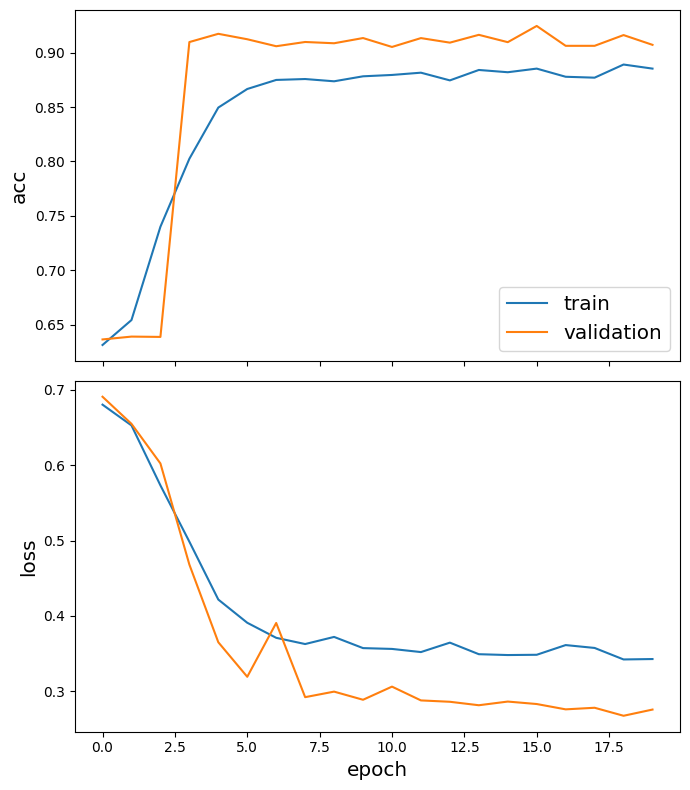

In [58]:
sg.utils.plot_history(history)

In [60]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  2/120 [..............................] - ETA: 7s - loss: 0.4930 - acc: 0.7750

2023-05-05 19:20:11.534480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


   4/2400 [..............................] - ETA: 1:06 - loss: 0.2091 - acc: 0.9000

2023-05-05 19:20:15.303117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2400/2400 [==============================] - 76s 32ms/step - loss: 0.2757 - acc: 0.9072

Train Set Metrics of the trained model:
	loss: 0.3053
	acc: 0.8896

Test Set Metrics of the trained model:
	loss: 0.2757
	acc: 0.9072


In [61]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import itertools

# Get the labels of the entire test set
y_true = np.concatenate([test_flow[i][1] for i in range(len(test_flow))])

# Predict the labels for the same set
y_pred = model.predict(test_flow)


# Compute the confusion matrix
cm = confusion_matrix(y_true, np.round(y_pred))

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

2023-05-05 19:22:22.040547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2400/2400 [==============================] - 73s 30ms/step


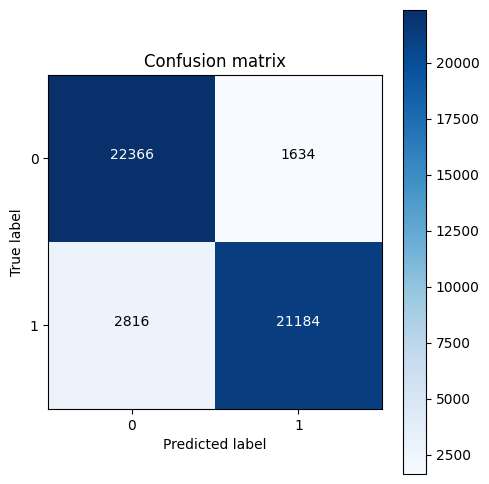

In [62]:
# Plot the confusion matrix
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues,label = True)
plt.title('Confusion matrix')
plt.colorbar()
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

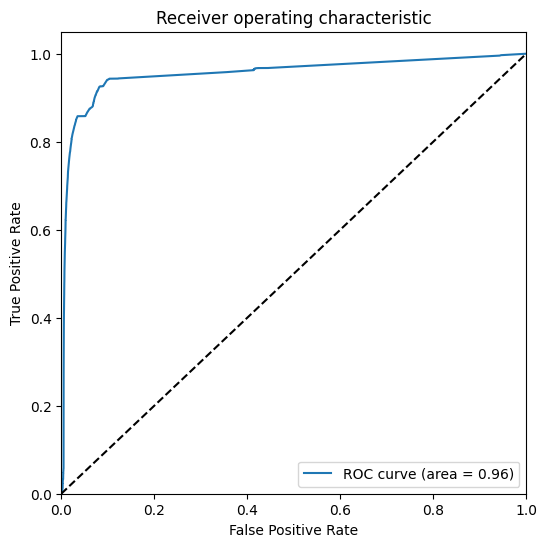

In [63]:
# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [64]:
# Save your GNN model
path = "Model_"+str(edges_considered)+".h5"
model.save(path)

In [1]:
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor

# Load the dataset into a pandas DataFrame
df = pd.read_csv("ratings.csv")
df = df[:20000]

# Create a directed graph of users and products
G = nx.DiGraph()

# Add edges between users and products, with the ratings as weights
for _, row in df.iterrows():
    user_id = row["UserId"]
    product_id = row["ProudctId"]
    rating = row["Rating"]
    G.add_edge(user_id, product_id, weight=rating)

# Calculate the PageRank centrality for each product in the graph
product_pageranks = nx.pagerank(G, weight='weight')

# Calculate the weighted cosine similarity between each pair of nodes in the graph
similarity_matrix = cosine_similarity(nx.to_numpy_array(G), dense_output=True)


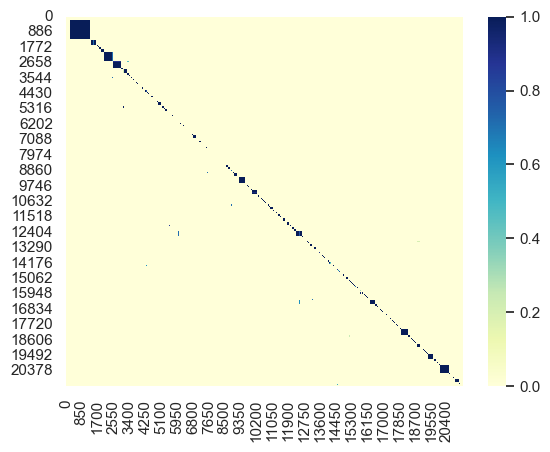

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
sns.heatmap(similarity_matrix, cmap="YlGnBu")
plt.show()

In [3]:
# Train a random forest regressor on the data, using both the PageRank centrality and the weighted cosine similarity as features
train_data = []
for _, row in df.iterrows():
    user_id = row["UserId"]
    product_id = row["ProudctId"]
    rating = row["Rating"]
    pagerank = product_pageranks[product_id]
    similarity = similarity_matrix[list(G.nodes()).index(user_id)][list(G.nodes()).index(product_id)]
    train_data.append([pagerank, similarity, rating])

train_df = pd.DataFrame(train_data, columns=['pagerank', 'similarity', 'rating'])
X_train = train_df[['pagerank', 'similarity']]
y_train = train_df['rating']
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Make recommendations for a given user
user_id = 'A2UVFEZ7UDBRAA'
user_items = df[df["UserId"] == user_id]["ProudctId"]
all_items = df["ProudctId"].unique()

# Remove the items already rated by the user
items_to_predict = list(set(all_items) - set(user_items))

# Predict ratings for the items the user has not yet rated
test_data = []
for item_id in items_to_predict:
    pagerank = product_pageranks[item_id]
    similarity = similarity_matrix[list(G.nodes()).index(user_id)][list(G.nodes()).index(item_id)]
    test_data.append([pagerank, similarity])

test_df = pd.DataFrame(test_data, columns=['pagerank', 'similarity'])
predictions = rf.predict(test_df)

# Sort the predictions in descending order by predicted rating
recommended_products = [item_id for _, item_id in sorted(zip(predictions, items_to_predict), reverse=True)][:3]

print("Top 3 recommended products for user {}: {}".format(user_id, recommended_products))

Top 3 recommended products for user A2UVFEZ7UDBRAA: ['B00000JLSJ', 'B00000J3NE', 'B00000J3G2']
